# <span style="color:gray">Zestimate and Actual Sale Price Difference</span>

 ## <span style="color:black">1. Define</span>   
 Problem -  
 >Predict the log-error between their Zestimate and the actual sale price, given all the features of a home.  
 >  
             log-error=log(Zestimate)−log(SalePrice)  
 > 
 > Predict the logerror for the months in Fall 2017
 
 What we have - 
 >a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.  
 >The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.  
 >The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.  
 >4 Categorical/Qualitative - companyId, jobType, degree, major, industry  
 >2 Numeric/Quantitative - yearsExperience, milesFromMetropolis  
 
 Model used -  
 > LightGBM  
 > XGBoost

 ## <span style="color:black">2. Discover</span> 

### <span style="color:black">2.1. Import Libraries</span> 

In [1]:
%%capture
! pip install seaborn
#import initial libraries
import pandas as pd
import numpy as np
from numpy import NaN
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 70)
#pd.set_option('display.width', 100)

### 2.2 Import data

In [2]:
import os
for dirname, _, filenames in os.walk('/Users/dad/Documents/GitHub/data/zillow/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/dad/Documents/GitHub/data/zillow/train_2017.csv
/Users/dad/Documents/GitHub/data/zillow/properties_2017.csv
/Users/dad/Documents/GitHub/data/zillow/properties_2016.csv
/Users/dad/Documents/GitHub/data/zillow/train_2016_v2.csv
/Users/dad/Documents/GitHub/data/zillow/sample_submission.csv


In [3]:
# load data
prop16 = pd.read_csv("/Users/dad/Documents/GitHub/data/zillow/properties_2016.csv")
prop17 = pd.read_csv("/Users/dad/Documents/GitHub/data/zillow/properties_2017.csv")
smplsub = pd.read_csv("/Users/dad/Documents/GitHub/data/zillow/sample_submission.csv")
train16 = pd.read_csv("/Users/dad/Documents/GitHub/data/zillow/train_2016_v2.csv", parse_dates=["transactiondate"])
train17 = pd.read_csv("/Users/dad/Documents/GitHub/data/zillow/train_2017.csv", parse_dates=["transactiondate"])


/Users/dad/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/dad/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 2.3 Feature & Observation Analysis

In [4]:
prop16.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [5]:
#function to get all info in one go
def full_info(df):
    df_column=[]
    df_dtype=[]
    df_null=[]
    df_nullc=[]
    df_mean=[]
    df_median=[]
    df_std=[]
    df_min=[]
    df_max=[]
    df_uniq=[]
    for col in df.columns: 
        df_column.append( col)
        df_dtype.append( df[col].dtype)
        df_null.append( round(100 * df[col].isnull().sum(axis=0)/len(df[col]),2))
        df_nullc.append( df[col].isnull().sum(axis=0))
        df_uniq.append( df[col].nunique()) if df[col].dtype == 'object' else df_uniq.append( NaN)
        df_mean.append(  '{0:.2f}'.format(df[col].mean())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_mean.append( NaN)
        df_median.append( '{0:.2f}'.format(df[col].median())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_median.append( NaN)
        df_std.append( '{0:.2f}'.format(df[col].std())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_std.append( NaN)
        df_max.append( '{0:.2f}'.format(df[col].max())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_max.append( NaN)
        df_min.append( '{0:.2f}'.format(df[col].min())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_min.append( NaN)
    return pd.DataFrame(data = {'ColName': df_column, 'ColType': df_dtype, 'NullCnt': df_nullc, 'NullCntPrcntg': df_null,  'Min': df_min, 'Max': df_max, 'Mean': df_mean, 'Med': df_median, 'Std': df_std, 'UniqCnt': df_uniq})

In [6]:
prop16_Info = full_info(prop16)
prop16_Info.sort_values(by=['NullCnt'], ascending=False, inplace=True, ignore_index=True)
prop16_Info

,ColName,ColType,NullCnt,NullCntPrcntg,Min,Max,Mean,Med,Std,UniqCnt
0,storytypeid,float64,2983593,99.95,7.00,7.00,7.00,7.00,0.00,NaN
1,basementsqft,float64,2983589,99.95,20.00,8516.00,646.88,534.00,538.79,NaN
2,yardbuildingsqft26,float64,2982570,99.91,10.00,6141.00,278.30,168.00,369.73,NaN
3,fireplaceflag,object,2980054,99.83,NaN,NaN,NaN,NaN,NaN,1.0
4,architecturalstyletypeid,float64,2979156,99.80,2.00,27.00,7.20,7.00,2.44,NaN
5,typeconstructiontypeid,float64,2978470,99.77,4.00,13.00,6.00,6.00,0.38,NaN
6,finishedsquarefeet13,float64,2977545,99.74,120.00,2688.00,1178.90,1296.00,357.07,NaN
7,buildingclasstypeid,float64,2972588,99.58,1.00,5.00,3.73,4.00,0.50,NaN
8,decktypeid,float64,2968121,99.43,66.00,66.00,66.00,66.00,0.00,NaN
9,finishedsquarefeet6,float64,2963216,99.26,117.00,952576.00,2414.34,1992.00,7695.30,NaN


In [7]:
train16.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [8]:
full_info(train16)

,ColName,ColType,NullCnt,NullCntPrcntg,Min,Max,Mean,Med,Std,UniqCnt
0,parcelid,int64,0,0.0,10711738.00,162960842.00,12984656.11,12547337.00,2504510.49,NaN
1,logerror,float64,0,0.0,-4.61,4.74,0.01,0.01,0.16,NaN
2,transactiondate,datetime64[ns],0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print('size of properties_2016.csv: ', prop16.shape)
print('size of train_2016_v2.csv: ', train16.shape)
print('size of properties_2017.csv: ', prop17.shape)
print('size of train_2017.csv: ', train17.shape)

size of properties_2016.csv:  (2985217, 58)
size of train_2016_v2.csv:  (90275, 3)
size of properties_2017.csv:  (2985217, 58)
size of train_2017.csv:  (77613, 3)


In [10]:
unique_props = len(train16['parcelid'].unique())
multiple_sales = len(train16) - unique_props
print('number of unique sales: ', unique_props)
print('Number of duplicate: ', multiple_sales)

number of unique sales:  90150
Number of duplicate:  125


In [11]:
smplsub.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


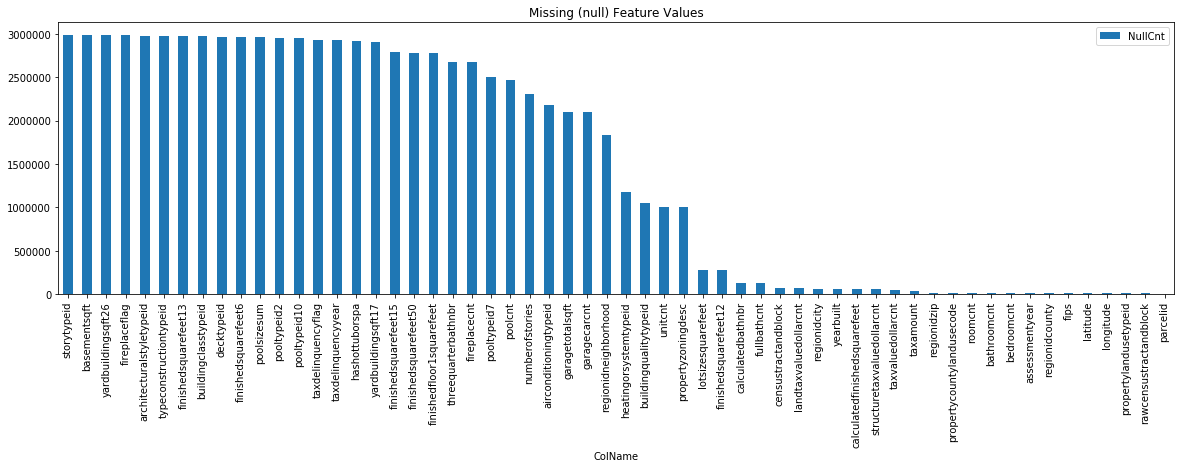

In [12]:
# lets visualize the Null Count percentage graphically
prop16_Info.plot.bar(x = 'ColName', y = 'NullCnt', figsize=(20, 5),rot=90, title='Missing (null) Feature Values')
plt.show()

### 2.4 Feature Engineering

In [13]:
# interactive feature transfromation.
prop16['prop_age'] = 2018 - prop16['yearbuilt']  # property age
prop16['has_basement'] = prop16['basementsqft'].apply(lambda x: 0 if np.isnan(x) else 1).astype(float)
prop16['has_pool'] = prop16[['poolcnt','poolsizesum','pooltypeid10','pooltypeid2','pooltypeid7']].apply(lambda x: 1 if(np.all(pd.notnull(x[1]))) else 0, axis = 1)
prop16['has_patio_yard'] = prop16['yardbuildingsqft17'].apply(lambda x: 0 if np.isnan(x) else 1).astype(float)
prop16['has_starage_yard'] = prop16['yardbuildingsqft26'].apply(lambda x: 0 if np.isnan(x) else 1).astype(float)
prop16['has_garage'] = prop16['garagecarcnt'].apply(lambda x: 0 if np.isnan(x) else 1).astype(float)

In [14]:
# some nan features actually make sense lets fill them with 0
prop16.yardbuildingsqft17.fillna(0, inplace=True)
prop16.yardbuildingsqft26.fillna(0, inplace=True)
prop16.basementsqft.fillna(0, inplace=True)
prop16.poolcnt.fillna(0, inplace=True)
prop16.poolsizesum.fillna(0, inplace=True)
prop16.pooltypeid10.fillna(0, inplace=True)
prop16.pooltypeid2.fillna(0, inplace=True)
prop16.pooltypeid7.fillna(0, inplace=True)
prop16.garagecarcnt.fillna(0, inplace=True)

In [15]:
# drop columns with data that has > 90% null
prop16_trim = prop16.drop(prop16_Info[(prop16_Info.NullCntPrcntg>=90)].ColName.values.tolist(), axis=1)
prop16_trim

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,prop_age,has_basement,has_pool,has_patio_yard,has_starage_yard,has_garage
0,10754147,NaN,0.0,0.0,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,0.0,NaN,NaN,34144442.0,-118654084.0,85768.0,0.0,0.0,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,0.0,0,0.0,0.0,0.0
1,10759547,NaN,0.0,0.0,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,0.0,NaN,NaN,34140430.0,-118625364.0,4083.0,0.0,0.0,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,0.0,0,0.0,0.0,0.0
2,10843547,NaN,0.0,0.0,NaN,NaN,73026.0,NaN,6037.0,NaN,NaN,0.0,NaN,NaN,33989359.0,-118394633.0,63085.0,0.0,0.0,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,2.0,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,0.0,0,0.0,0.0,0.0
3,10859147,NaN,0.0,0.0,7.0,NaN,5068.0,NaN,6037.0,NaN,NaN,0.0,NaN,NaN,34148863.0,-118437206.0,7521.0,0.0,0.0,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,1948.0,1.0,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,70.0,0.0,0,0.0,0.0,0.0
4,10879947,NaN,0.0,0.0,NaN,NaN,1776.0,NaN,6037.0,NaN,NaN,0.0,NaN,NaN,34194168.0,-118385816.0,8512.0,0.0,0.0,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,1.0,1947.0,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,71.0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0,0.0
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0,0.0
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0,0.0
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0,0.0


In [16]:
prop16_trim.select_dtypes(include=['object']).columns

Index(['propertycountylandusecode', 'propertyzoningdesc'], dtype='object')

In [17]:
# these object dtype not categorical. can be ignored.
prop16_trim[['propertycountylandusecode', 'propertyzoningdesc']]

,propertycountylandusecode,propertyzoningdesc
0,010D,NaN
1,0109,LCA11*
2,1200,LAC2
3,1200,LAC2
4,1210,LAM1
...,...,...
2985212,NaN,NaN
2985213,NaN,NaN
2985214,NaN,NaN
2985215,NaN,NaN


In [18]:
# drop the object dtype columns
prop16_trim=prop16_trim.drop(['propertycountylandusecode', 'propertyzoningdesc'],axis=1)

In [19]:
# lets fill rest of the NaNs with medians
prop16_median_imputed = prop16_trim.fillna(prop16_trim.median())
prop16_median_imputed

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,prop_age,has_basement,has_pool,has_patio_yard,has_starage_yard,has_garage
0,10754147,1.0,0.0,0.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,0.0,441.0,2.0,34144442.0,-118654084.0,85768.0,0.0,0.0,269.0,6.037800e+07,37688.0,3101.0,118920.0,96337.0,0.0,1.0,1.0,1963.0,1.0,122590.0,9.0,2015.0,9.0,3991.78,6.037572e+13,55.0,0.0,0,0.0,0.0,0.0
1,10759547,1.0,0.0,0.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,0.0,441.0,2.0,34140430.0,-118625364.0,4083.0,0.0,0.0,261.0,6.037800e+07,37688.0,3101.0,118920.0,96337.0,0.0,1.0,1.0,1963.0,1.0,122590.0,27516.0,2015.0,27516.0,3991.78,6.037572e+13,55.0,0.0,0,0.0,0.0,0.0
2,10843547,1.0,0.0,0.0,7.0,2.0,73026.0,1539.0,6037.0,1.0,2.0,0.0,441.0,2.0,33989359.0,-118394633.0,63085.0,0.0,0.0,47.0,6.037703e+07,51617.0,3101.0,118920.0,96095.0,0.0,1.0,2.0,1963.0,1.0,650756.0,1413387.0,2015.0,762631.0,20800.37,6.037572e+13,55.0,0.0,0,0.0,0.0,0.0
3,10859147,1.0,0.0,0.0,7.0,2.0,5068.0,1539.0,6037.0,1.0,2.0,0.0,441.0,2.0,34148863.0,-118437206.0,7521.0,0.0,0.0,47.0,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,1.0,1.0,1948.0,1.0,571346.0,1156834.0,2015.0,585488.0,14557.57,6.037572e+13,70.0,0.0,0,0.0,0.0,0.0
4,10879947,1.0,0.0,0.0,7.0,2.0,1776.0,1539.0,6037.0,1.0,2.0,0.0,441.0,2.0,34194168.0,-118385816.0,8512.0,0.0,0.0,31.0,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,1.0,1.0,1947.0,1.0,193796.0,433491.0,2015.0,239695.0,5725.17,6.037572e+13,71.0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,1.0,2.0,3.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,0.0,441.0,2.0,34008249.0,-118172540.5,7000.0,0.0,0.0,261.0,6.037571e+07,25218.0,3101.0,118920.0,96377.0,0.0,1.0,1.0,1963.0,1.0,122590.0,306086.0,2015.0,167042.0,3991.78,6.037572e+13,55.0,0.0,0,0.0,0.0,0.0
2985213,14273630,1.0,2.0,3.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,0.0,441.0,2.0,34008249.0,-118172540.5,7000.0,0.0,0.0,261.0,6.037571e+07,25218.0,3101.0,118920.0,96377.0,0.0,1.0,1.0,1963.0,1.0,122590.0,306086.0,2015.0,167042.0,3991.78,6.037572e+13,55.0,0.0,0,0.0,0.0,0.0
2985214,168040630,1.0,2.0,3.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,0.0,441.0,2.0,34008249.0,-118172540.5,7000.0,0.0,0.0,261.0,6.037571e+07,25218.0,3101.0,118920.0,96377.0,0.0,1.0,1.0,1963.0,1.0,122590.0,306086.0,2015.0,167042.0,3991.78,6.037572e+13,55.0,0.0,0,0.0,0.0,0.0
2985215,168040830,1.0,2.0,3.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,0.0,441.0,2.0,34008249.0,-118172540.5,7000.0,0.0,0.0,261.0,6.037571e+07,25218.0,3101.0,118920.0,96377.0,0.0,1.0,1.0,1963.0,1.0,122590.0,306086.0,2015.0,167042.0,3991.78,6.037572e+13,55.0,0.0,0,0.0,0.0,0.0


In [20]:
# lets concatenated both property and train data
train16_merge = pd.merge(prop16_median_imputed, train16, on='parcelid', how='inner')
train16_merge

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,prop_age,has_basement,has_pool,has_patio_yard,has_starage_yard,has_garage,logerror,transactiondate
0,17073783,1.0,2.5,3.0,7.0,2.5,1264.0,1264.0,6111.0,1.0,2.0,2.0,0.0,2.0,34303597.0,-119287236.0,1735.0,0.0,0.0,265.0,6.111002e+07,34543.0,2061.0,118920.0,97081.0,5.0,1.0,1.0,1986.0,2.0,115087.0,191811.0,2015.0,76724.0,2015.06,6.111002e+13,32.0,0.0,0,1.0,0.0,1.0,0.0953,2016-01-27
1,17088994,1.0,1.0,2.0,7.0,1.0,777.0,777.0,6111.0,1.0,1.0,1.0,0.0,2.0,34272866.0,-119198911.0,7000.0,0.0,0.0,266.0,6.111002e+07,34543.0,2061.0,118920.0,97083.0,4.0,1.0,1.0,1990.0,1.0,143809.0,239679.0,2015.0,95870.0,2581.30,6.111002e+13,28.0,0.0,0,1.0,0.0,1.0,0.0198,2016-03-30
2,17100444,1.0,2.0,3.0,7.0,2.0,1101.0,1101.0,6111.0,1.0,2.0,2.0,441.0,2.0,34340801.0,-119079610.0,6569.0,0.0,0.0,261.0,6.111001e+07,26965.0,2061.0,118920.0,97113.0,5.0,1.0,1.0,1956.0,1.0,33619.0,47853.0,2015.0,14234.0,591.64,6.111001e+13,62.0,0.0,0,0.0,0.0,1.0,0.0060,2016-05-27
3,17102429,1.0,1.5,2.0,7.0,1.5,1554.0,1554.0,6111.0,1.0,1.0,2.0,460.0,2.0,34354313.0,-119076405.0,7400.0,0.0,0.0,261.0,6.111001e+07,26965.0,2061.0,118920.0,97113.0,5.0,1.0,1.0,1965.0,1.0,45609.0,62914.0,2015.0,17305.0,682.78,6.111001e+13,53.0,0.0,0,0.0,0.0,1.0,-0.0566,2016-06-07
4,17109604,1.0,2.5,4.0,7.0,2.5,2415.0,2415.0,6111.0,1.0,2.0,2.0,665.0,2.0,34266578.0,-119165392.0,6326.0,0.0,0.0,261.0,6.111001e+07,34543.0,2061.0,118920.0,97084.0,8.0,1.0,1.0,1984.0,2.0,277000.0,554000.0,2015.0,277000.0,5886.92,6.111001e+13,34.0,0.0,0,0.0,0.0,1.0,0.0573,2016-08-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,11876798,1.0,3.0,4.0,4.0,3.0,2068.0,2068.0,6037.0,1.0,3.0,0.0,441.0,2.0,34097523.0,-118164828.0,4981.0,0.0,0.0,261.0,6.037201e+07,12447.0,3101.0,114914.0,96013.0,0.0,1.0,1.0,2008.0,1.0,388582.0,596082.0,2015.0,207500.0,7335.81,6.037201e+13,10.0,0.0,0,0.0,0.0,0.0,0.0276,2016-04-15
90271,12808516,1.0,2.0,3.0,7.0,2.0,1352.0,1352.0,6037.0,1.0,2.0,0.0,441.0,7.0,34045228.0,-117971653.0,6170.0,0.0,0.0,261.0,6.037407e+07,39306.0,3101.0,118920.0,96490.0,0.0,1.0,1.0,1956.0,1.0,86209.0,178408.0,2015.0,92199.0,2441.74,6.037407e+13,62.0,0.0,0,0.0,0.0,0.0,-0.1188,2016-06-07
90272,12010248,1.0,2.0,2.0,4.0,2.0,860.0,860.0,6037.0,1.0,2.0,0.0,441.0,2.0,34100819.0,-118311704.0,7000.0,0.0,0.0,266.0,6.037191e+07,12447.0,3101.0,32059.0,96009.0,0.0,1.0,1.0,2011.0,1.0,129000.0,420000.0,2015.0,291000.0,5070.41,6.037191e+13,7.0,0.0,0,0.0,0.0,0.0,0.0843,2016-06-30
90273,14310905,1.0,2.5,3.0,7.0,2.5,2268.0,2268.0,6059.0,1.0,2.0,2.0,427.0,2.0,33660088.0,-117804958.0,3479.0,0.0,0.0,261.0,6.059063e+07,52650.0,1286.0,275824.0,96947.0,0.0,1.0,1.0,2012.0,1.0,389474.0,1215816.0,2015.0,826342.0,12508.30,6.037572e+13,6.0,0.0,0,0.0,0.0,1.0,-0.0050,2016-03-31


In [21]:
 train16_merge=train16_merge.drop(['parcelid'],axis=1)

### 2.5 Correlation

/Users/dad/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/dad/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/dad/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


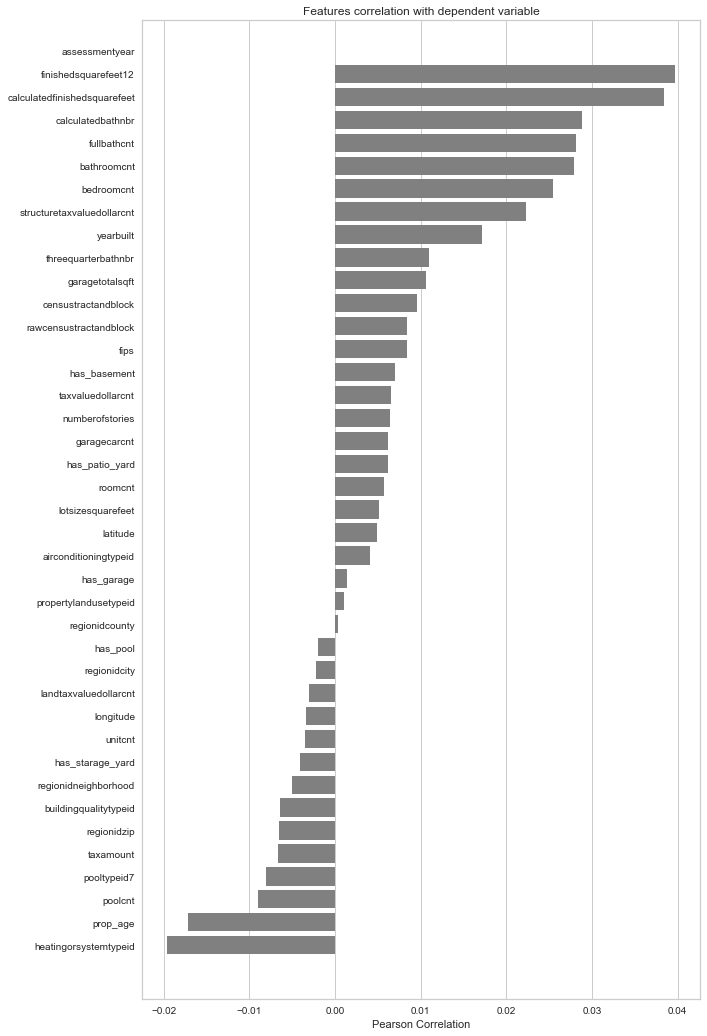

In [23]:
# lets check the correlation of the feature to target
from yellowbrick.target.feature_correlation import feature_correlation
X, y = train16_merge.drop(columns =[ 'logerror', 'transactiondate', 'fireplacecnt']), train16_merge['logerror']

features = np.array(train16_merge.drop(columns = [ 'logerror', 'transactiondate', 'fireplacecnt']).columns )
fig, ax = plt.subplots(figsize=(10,18))
visualizer = feature_correlation(X, y, labels=features, sort= True, color='gray', show=True, ax=ax)
plt.show()

# 3. Develop

### 3.1 LightGBM Model

In [24]:
# import LightGBM Libraries

import lightgbm as lgb
import random

In [22]:
#LightGBM accepts numphy array as input
x_train = train16_merge.drop(columns =[ 'logerror', 'transactiondate', 'fireplacecnt']).values.astype(np.float32) # np array
y_train = train16_merge['logerror'].values.astype(np.float32)  # np array
x_test = train16_merge.drop([ 'logerror', 'transactiondate', 'fireplacecnt'], axis=1).values.astype(np.float32)  # np array
train_columns = train16_merge.drop(columns = [ 'logerror', 'transactiondate', 'fireplacecnt']).columns 

In [25]:
# manually added the features as the numbers in some features is not acceptable for lgb
d_train = lgb.Dataset(x_train, y_train, feature_name=['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet', 'fips',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'pooltypeid', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'prop_age', 'has_basement',
       'has_pool', 'has_patio_yard', 'has_starage_yard','has_garage'])  # lightgbm data model

In [26]:
# lgb hyper parameters
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.01  # shrinkage_rate 0.0021 grid search = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'  # l1
params['sub_feature'] = 0.5  # feature_fraction
params['bagging_fraction'] = 0.85  # sub_row
params['num_leaves'] = 512  # num_leaf
params['min_data'] = 500  # min_data_in_leaf
params['min_hessian'] = 0.05  # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3
#params['n_estimators'] = 10  # grid search
params['colsample_bytree'] = 0.85
params['num_leaves'] = 22
params['subsample'] = 0.7

np.random.seed(0)
random.seed(0)

In [27]:
# lgb train
clf = lgb.train(params, d_train, 430)

In [28]:
# lgb predict

p_test = clf.predict(x_test)
pd.DataFrame(p_test).head()

,0
0,0.016736
1,0.006687
2,0.023901
3,0.030462
4,0.013381


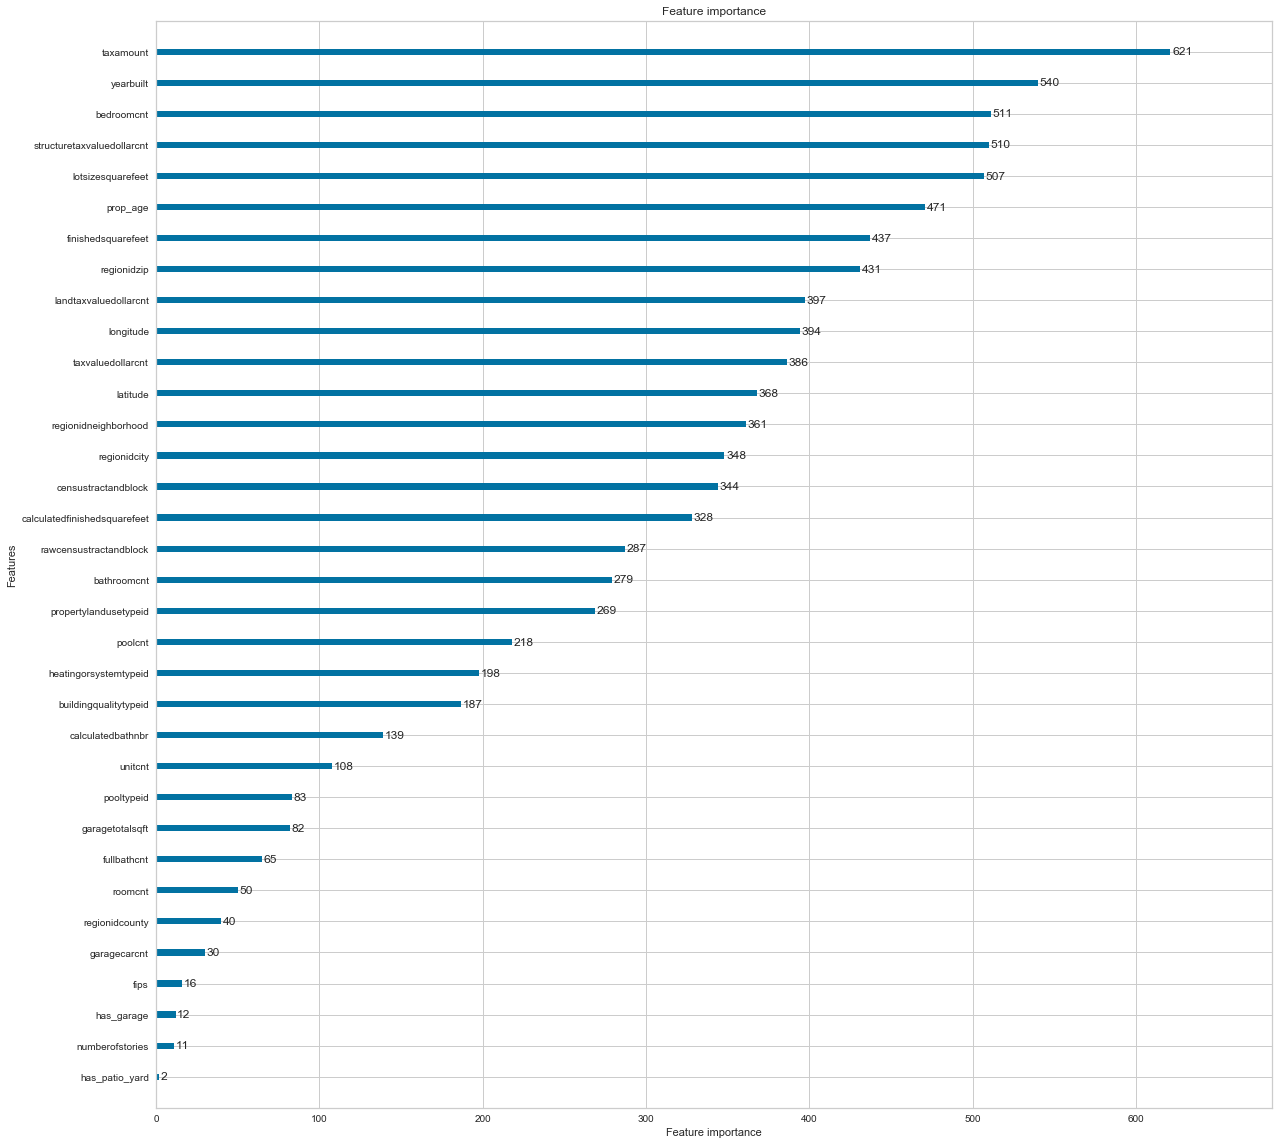

In [29]:
# lgb feature importance
lgb.plot_importance(clf, figsize=(20,20))
plt.show()

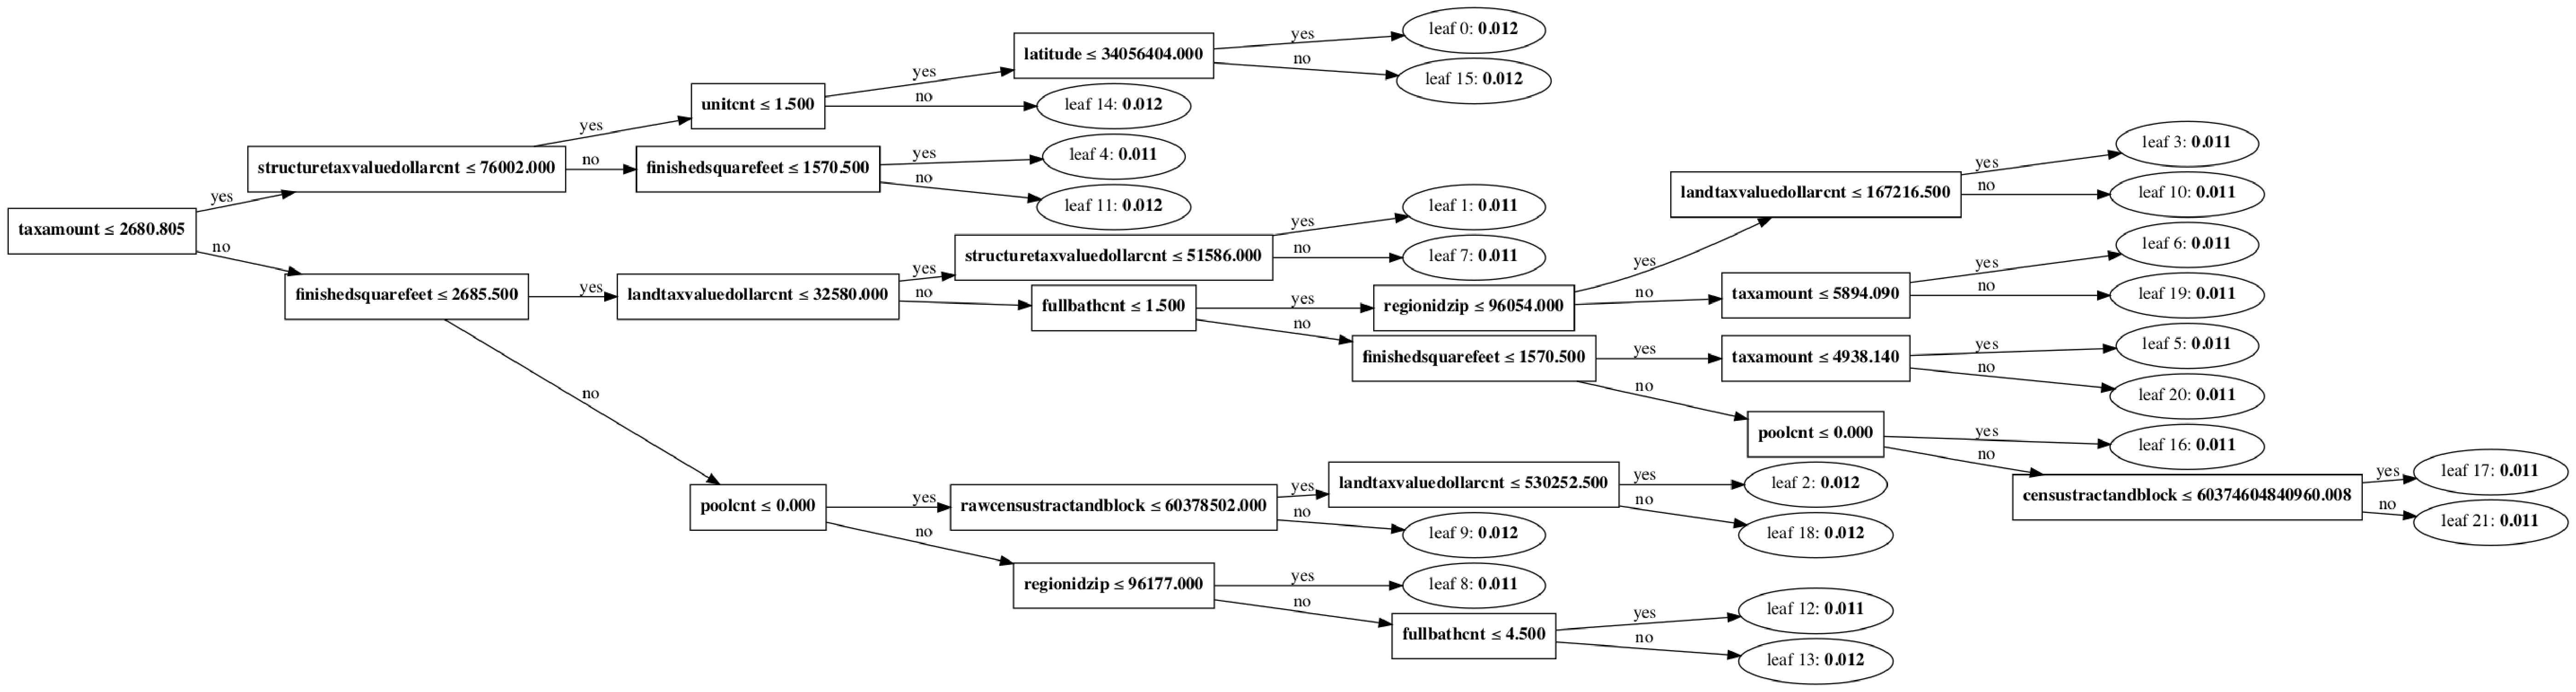

In [30]:
# lgb tree plot
import os
os.environ["PATH"] += os.pathsep + '/opt/anaconda3/lib/python3.7/site-packages/sphinx/templates/graphviz'
lgb.plot_tree(clf, figsize=(100,40))
plt.show()

### 3.2 XGBoost Model

In [ ]:
# import the library
import xgboost as xgb

In [31]:
#XGBoost instead accepts dataframe as input
x_train_xgb = train16_merge.drop(columns =[ 'logerror', 'transactiondate', 'fireplacecnt']) 
y_train_xgb = train16_merge['logerror']
x_test_xgb = train16_merge.drop([ 'logerror', 'transactiondate', 'fireplacecnt'], axis=1)
train_columns_xgb = train16_merge.drop(columns = [ 'logerror', 'transactiondate', 'fireplacecnt']).columns 

In [32]:
# xgb hyperparameters

y_mean = np.mean(y_train_xgb)
xgb_params1 = {
    'eta' : 0.04,  # 0.037 grid search = .04
    'max_depth' : 6,  #5
    'subsample' : 0.80,
    'objective' : 'reg:linear',
    'eval_metric' : 'mae',
    'lambda' : 0.8,
    'alpha' : 0.4,
    'base_score' : y_mean,
    'silent' : 1,
    'min_child_weight': 5  # grid search
}

In [33]:
dtrain1 = xgb.DMatrix(x_train_xgb, y_train_xgb, feature_names=train_columns_xgb)
dtest1 = xgb.DMatrix(x_test_xgb)

In [34]:
# training
model1 = xgb.train(dict(xgb_params1, silent=1), dtrain1, num_boost_round=150)

In [35]:
# predict
xgb_pred1 = model1.predict(dtest1)
xgb_pred1

array([0.01864707, 0.01056658, 0.01993646, ..., 0.00449685, 0.00793498,
       0.00852457], dtype=float32)

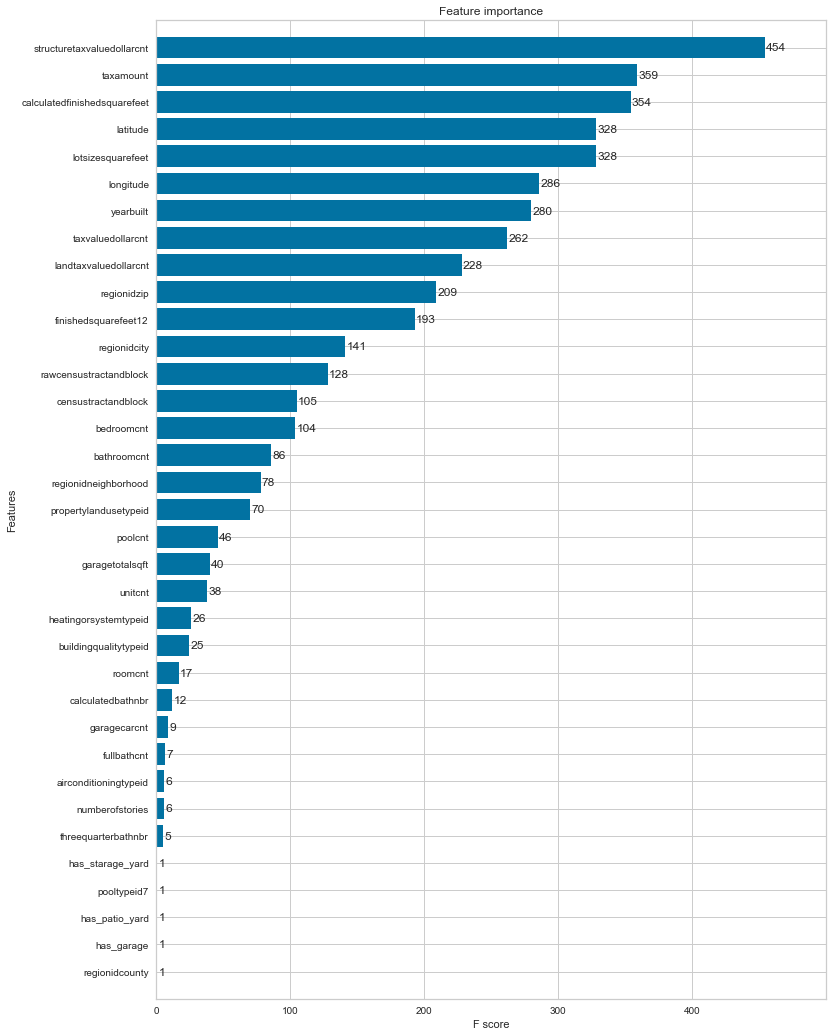

In [36]:
# xgb feature importance
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model1, max_num_features=50, height=0.8, ax=ax)
plt.show()

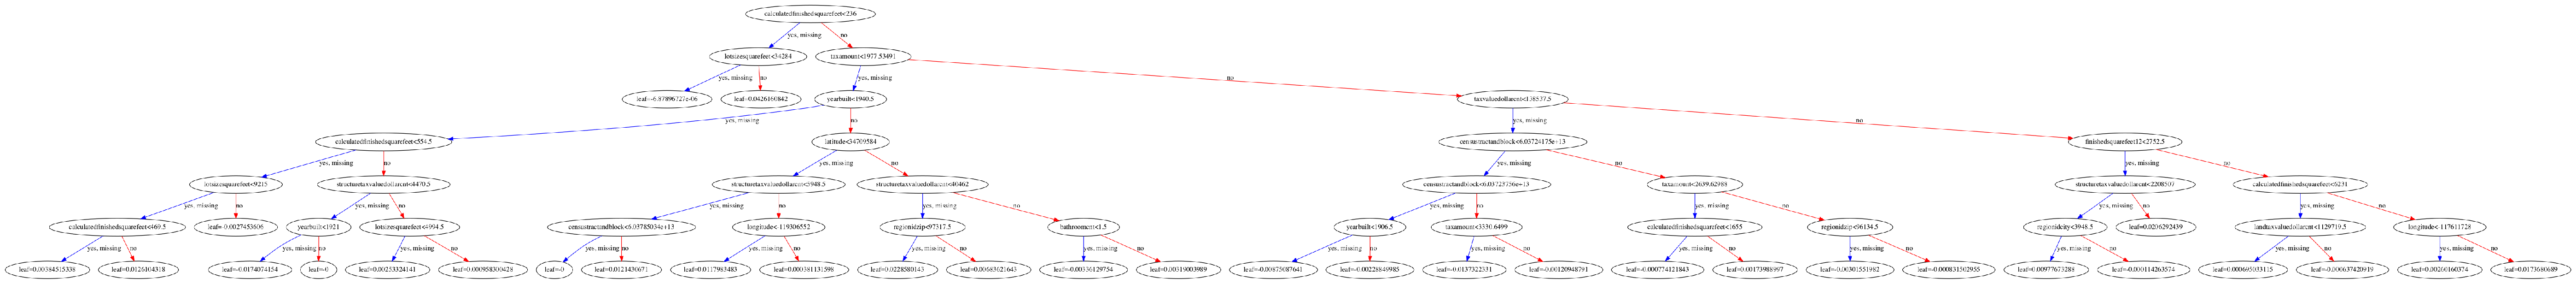

In [37]:
fig, ax = plt.subplots(figsize=(100, 60))
xgb.plot_tree(model1, num_trees=4, ax=ax)
plt.show()

### 3.3 XGBoost with a variation

In [38]:
# xgb2 hyperparameters
xgb_params2 = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'silent': 1,
    'seed' : 0
}
dtrain2 = xgb.DMatrix(x_train_xgb, y_train_xgb, feature_names=train_columns)
dtest2 = xgb.DMatrix(x_test_xgb)

In [39]:
# training
model2 = xgb.train(dict(xgb_params2, silent=0), dtrain2, num_boost_round=50)

In [40]:
# predict
xgb_pred2 = model2.predict(dtest2)
xgb_pred2

array([0.05062059, 0.04674411, 0.05712289, ..., 0.04249883, 0.05007419,
       0.04646474], dtype=float32)

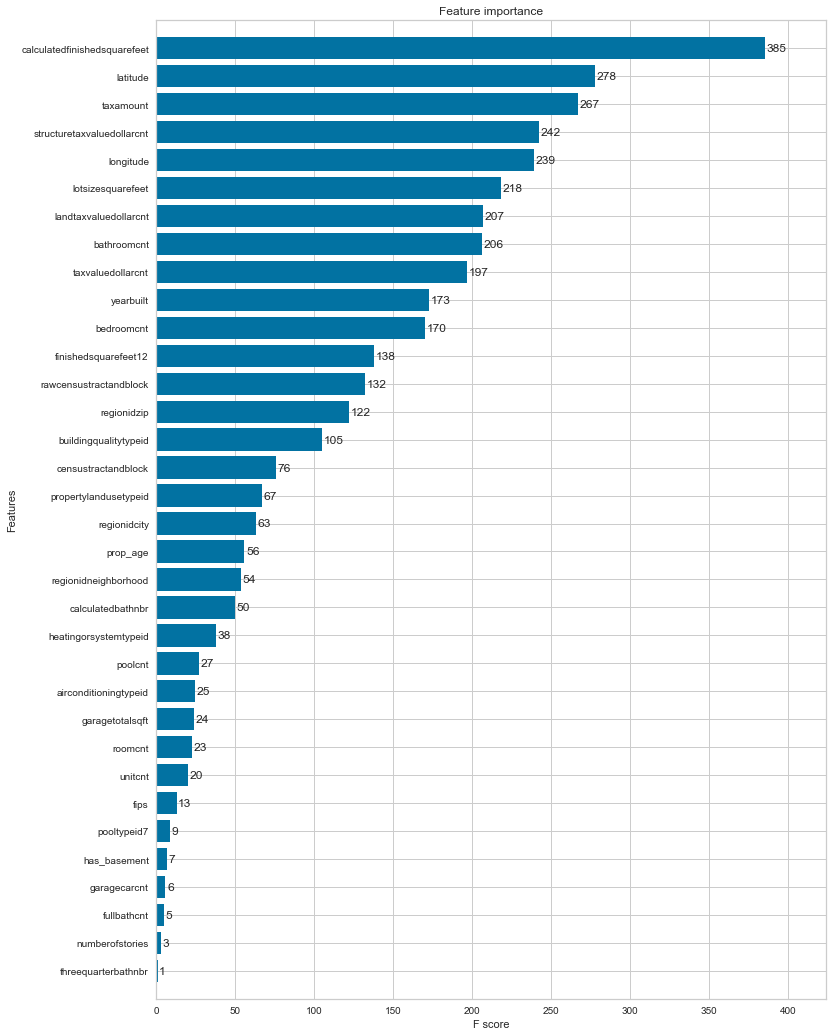

In [41]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model2, max_num_features=50, height=0.8, ax=ax)
plt.show()

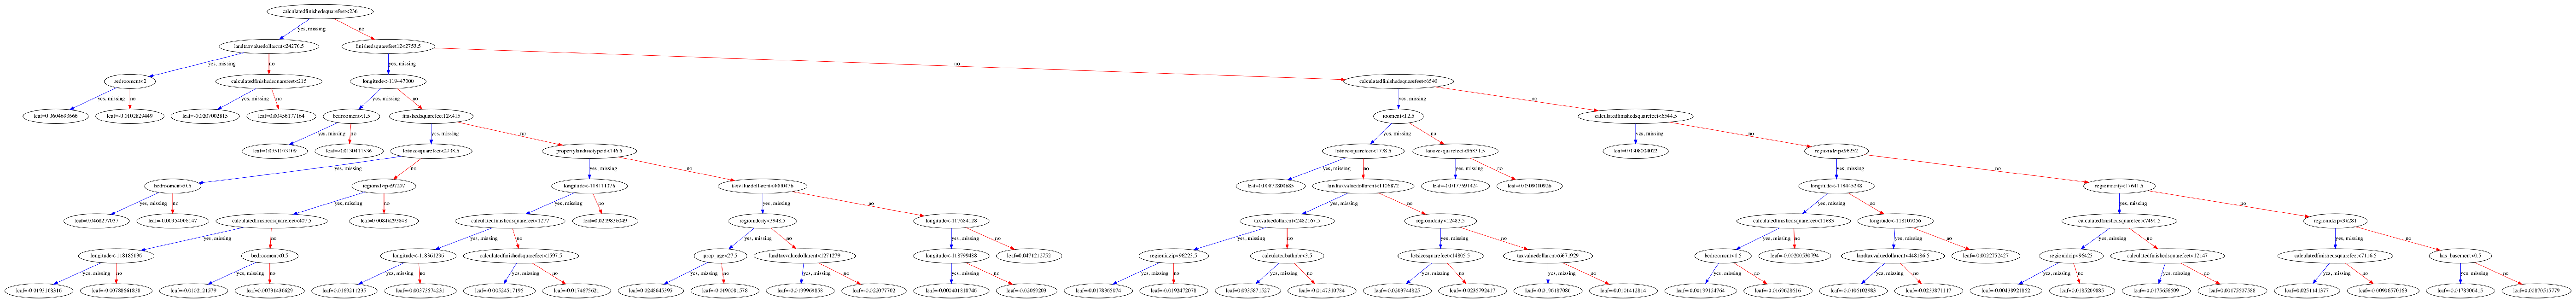

In [42]:
fig, ax = plt.subplots(figsize=(100, 60))
xgb.plot_tree(model2, num_trees=4, ax=ax)
plt.show()